In [1]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

ventas_dia = pd.read_csv("data/processed/ventas_diarias.csv",
                         parse_dates=["InvoiceDate"], index_col="InvoiceDate")["TotalPrice"].asfreq("D")

In [4]:
df_km = ventas_dia.to_frame("TotalPrice")
df_km["weekday"] = df_km.index.weekday
df_km["is_weekend"] = (df_km["weekday"] >= 5).astype(int)

scaler = StandardScaler().fit(df_km[["TotalPrice","weekday","is_weekend"]])
X_scaled = scaler.transform(df_km[["TotalPrice","weekday","is_weekend"]])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)

os.makedirs("models", exist_ok=True)
with open("models/trained_model_008_kmeans.pkl","wb") as f:
    pickle.dump({"scaler":scaler,"model":kmeans,"feature_cols":["TotalPrice","weekday","is_weekend"]}, f)

cluster_df = pd.DataFrame({"cluster": kmeans.predict(X_scaled)}, index=df_km.index)
cluster_df.to_csv("data/processed/cluster_labels_por_dia.csv")
print("KMeans y labels guardados.")

KMeans y labels guardados.


In [5]:
iso = IsolationForest(contamination=0.05, random_state=42).fit(df_km[["TotalPrice","weekday","is_weekend"]])
with open("models/trained_model_009_iso.pkl","wb") as f:
    pickle.dump({"model":iso,"feature_cols":["TotalPrice","weekday","is_weekend"]}, f)

anom_df = pd.DataFrame({"anomaly": iso.predict(df_km[["TotalPrice","weekday","is_weekend"]])}, index=df_km.index)
anom_df.to_csv("data/processed/anomalies.csv")
print("IsolationForest y etiquetas guardados.")

IsolationForest y etiquetas guardados.


In [6]:
df_feat = pd.read_csv("data/processed/ventas_con_features.csv",
                      parse_dates=["InvoiceDate"], index_col="InvoiceDate")

clusters = pd.read_csv("data/processed/cluster_labels_por_dia.csv",
                       parse_dates=["InvoiceDate"], index_col="InvoiceDate")
anoms = pd.read_csv("data/processed/anomalies.csv",
                    parse_dates=["InvoiceDate"], index_col="InvoiceDate")

df_feat_u = df_feat.join(clusters, how="left").join(anoms, how="left").dropna()
cut = pd.to_datetime("2011-03-01")
X_u = df_feat_u.drop(columns="y"); y_u = df_feat_u["y"]
X_train_u, X_test_u = X_u.loc[X_u.index < cut], X_u.loc[X_u.index >= cut]
y_train_u, y_test_u = y_u.loc[y_u.index < cut], y_u.loc[y_u.index >= cut]

print("Shapes RF+unsup ->", X_train_u.shape, X_test_u.shape)

Shapes RF+unsup -> (42, 9) (30, 9)


In [7]:
rf_us = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=1, random_state=42)
rf_us.fit(X_train_u, y_train_u)
pred_us = pd.Series(rf_us.predict(X_test_u), index=X_test_u.index)

mae_us = mean_absolute_error(y_test_u, pred_us); rmse_us = np.sqrt(mean_squared_error(y_test_u, pred_us))
print(f"RandomForest + (cluster, anomaly) -> MAE: {mae_us:.2f} | RMSE: {rmse_us:.2f}")

imp = pd.Series(rf_us.feature_importances_, index=X_train_u.columns).sort_values(ascending=False)
display(imp.head(12))

RandomForest + (cluster, anomaly) -> MAE: 3694.26 | RMSE: 5631.72


cluster       0.376190
weekday       0.210761
is_weekend    0.109769
anomaly       0.087910
lag7          0.085964
lag14         0.047878
lag1          0.033986
ma14          0.031522
ma7           0.016019
dtype: float64

In [9]:
with open("models/trained_model_008_kmeans.pkl","rb") as f: km_art = pickle.load(f)
with open("models/trained_model_009_iso.pkl","rb") as f: iso_art = pickle.load(f)

final_artifacts = {
    "rf_model": rf_us,
    "feature_columns": X_train_u.columns.tolist(),
    "feature_config": {"lags":[1,7,14], "ma_windows":[7,14]},
    "kmeans": km_art,
    "isoforest": iso_art
}
with open("models/final_model.pkl","wb") as f:
    pickle.dump(final_artifacts, f)
print("Guardado modelo final en models/final_model.pkl")

Guardado modelo final en models/final_model.pkl


In [10]:
def predict_final_model(X: pd.DataFrame, final_model: dict):
    rf_model = final_model["rf_model"]
    feature_cols = final_model["feature_columns"]
    X_aligned = X.reindex(columns=feature_cols, fill_value=0)
    return rf_model.predict(X_aligned)

with open("models/final_model.pkl","rb") as f:
    final_model = pickle.load(f)

y_pred_final = predict_final_model(X_test_u, final_model)

mae_final = mean_absolute_error(y_test_u, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_u, y_pred_final))
print(f"FINAL -> MAE: {mae_final:.2f} | RMSE: {rmse_final:.2f}")

pd.DataFrame({"y_real": y_test_u, "y_pred": y_pred_final}, index=X_test_u.index)\
  .to_csv("data/test/predicciones_final.csv")
pd.DataFrame({"MAE":[mae_final], "RMSE":[rmse_final]}).to_csv("data/test/metricas_final.csv", index=False)
print("Guardados: data/test/predicciones_final.csv y data/test/metricas_final.csv")

FINAL -> MAE: 3694.26 | RMSE: 5631.72
Guardados: data/test/predicciones_final.csv y data/test/metricas_final.csv


Próximos 7 días:
 2011-03-31    17567.07
2011-04-01    20095.22
2011-04-02     5498.20
2011-04-03     1983.99
2011-04-04    18607.61
2011-04-05    18783.78
2011-04-06    22929.86
Freq: D, dtype: float64


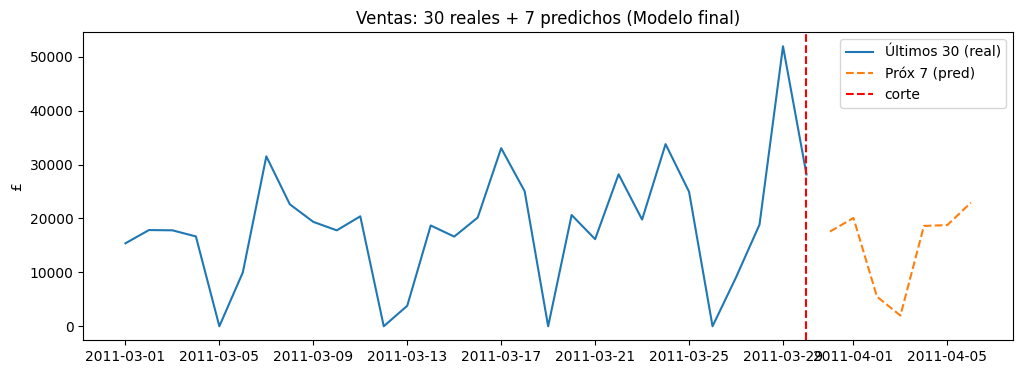

In [11]:
def build_base_features(series: pd.Series, lags=[1,7,14], ma_windows=[7,14]):
    s = series.asfreq("D").copy()
    df = pd.DataFrame({"y": s})
    for L in lags:
        df[f"lag{L}"] = df["y"].shift(L)
    for W in ma_windows:
        df[f"ma{W}"] = df["y"].rolling(W, min_periods=W).mean().shift(1)
    df["weekday"] = df.index.weekday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    return df

def _km_iso_for_date(date, y_guess, km_scaler, km_model, km_cols, iso_model, iso_cols):
    weekday = date.weekday(); is_weekend = int(weekday >= 5)
    row = {"TotalPrice": float(y_guess), "weekday": weekday, "is_weekend": is_weekend}
    df_tmp = pd.DataFrame([row], index=[date])
    clus = int(km_model.predict(km_scaler.transform(df_tmp[km_cols]))[0])
    anom = int(iso_model.predict(df_tmp[iso_cols])[0])
    return clus, anom

def forecast_next_n_rf_unsupervised(series, artifacts, N=7):
    rf_model = artifacts["rf_model"]; rf_cols = artifacts["feature_columns"]
    cfg = artifacts["feature_config"]
    km_scaler = artifacts["kmeans"]["scaler"]; km_model = artifacts["kmeans"]["model"]; km_cols = artifacts["kmeans"]["feature_cols"]
    iso_model = artifacts["isoforest"]["model"]; iso_cols = artifacts["isoforest"]["feature_cols"]

    s_hist = series.asfreq("D").copy()
    preds, current_date = [], s_hist.index[-1]

    for _ in range(N):
        next_date = current_date + pd.Timedelta(days=1)
        df_base = build_base_features(s_hist, **cfg).dropna()
        last_row = df_base.iloc[[-1]].copy()

        ma7 = last_row.get("ma7", pd.Series([np.nan])).values[0]
        lag1 = last_row.get("lag1", pd.Series([np.nan])).values[0]
        y_guess = ma7 if np.isfinite(ma7) else (lag1 if np.isfinite(lag1) else float(s_hist.iloc[-1]))

        clus, anom = _km_iso_for_date(next_date, y_guess, km_scaler, km_model, km_cols, iso_model, iso_cols)

        x_future = last_row.drop(columns=["y"], errors="ignore").copy()
        x_future["weekday"] = next_date.weekday()
        x_future["is_weekend"] = int(next_date.weekday() >= 5)
        x_future["cluster"] = clus
        x_future["anomaly"] = anom
        x_future = x_future.reindex(columns=rf_cols, fill_value=0)

        y_hat1 = float(rf_model.predict(x_future)[0])
        clus2, anom2 = _km_iso_for_date(next_date, y_hat1, km_scaler, km_model, km_cols, iso_model, iso_cols)
        x_future["cluster"] = clus2; x_future["anomaly"] = anom2
        y_hat = float(rf_model.predict(x_future)[0])

        preds.append(y_hat)
        s_hist = pd.concat([s_hist, pd.Series([y_hat], index=[next_date])])
        current_date = next_date

    future_index = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=N, freq="D")
    return pd.Series(preds, index=future_index)

with open("models/final_model.pkl","rb") as f:
    final_model = pickle.load(f)

pred_7 = forecast_next_n_rf_unsupervised(ventas_dia, final_model, N=7)
print("Próximos 7 días:\n", pred_7.round(2))
pred_7.to_frame("forecast_next_7d").to_csv("data/processed/forecast_next_7_days.csv")

last_30 = ventas_dia.tail(30)
plt.figure(figsize=(12,4))
plt.plot(last_30.index, last_30.values, label="Últimos 30 (real)")
plt.plot(pred_7.index, pred_7.values, "--", label="Próx 7 (pred)")
plt.axvline(last_30.index[-1], color="red", linestyle="--", label="corte")
plt.title("Ventas: 30 reales + 7 predichos (Modelo final)")
plt.ylabel("£"); plt.legend()